# More bike tripping

It makes symmetrical sense to point bikes which started the day at a station against bikes that ended the day there. This is that latter half.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import io
import zipfile
from tqdm import tqdm

In [2]:
stations = pd.read_csv("../data/final/june_22_station_metadata.csv", index_col=0)

In [3]:
june_22 = pd.read_csv("../data/final/all_june_22_citibike_trips.csv", index_col=0)

In [4]:
june_22.head(2)

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1004842,25585,1978.0,450,40.762272,-73.987882,W 49 St & 8 Ave,1,334,40.742388,-73.997262,W 20 St & 7 Ave,6/22/2016 00:00:11,6/22/2016 00:13:17,785,Subscriber
1004843,23365,1997.0,486,40.746201,-73.988557,Broadway & W 29 St,1,529,40.757570,-73.990985,W 42 St & 8 Ave,6/22/2016 00:00:29,6/22/2016 00:08:00,450,Subscriber


In [5]:
station_bikesets = {station_id: [] for station_id in stations.index}

for bike_id in tqdm(np.unique(june_22['bikeid'])):
    first_trip_station = june_22[june_22['bikeid'] == bike_id].sort_values(by='starttime', ascending=False).iloc[0]['start station id']
    station_bikesets[first_trip_station].append(bike_id)

100%|████████████████████████████████████| 6493/6493 [00:05<00:00, 1100.26it/s]


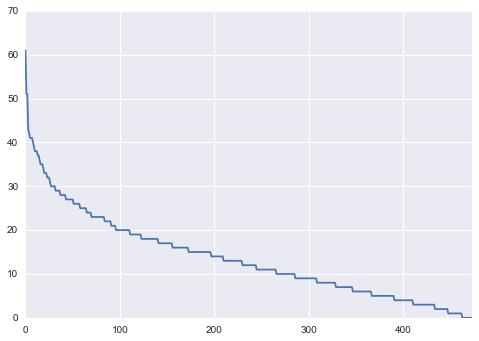

In [6]:
# Stations by number of bikes which started the day there.
pd.Series([len(station_bikesets[key]) for key in station_bikesets.keys()]).sort_values(ascending=False).reset_index(drop=True).plot()

In [7]:
pd.Series([len(station_bikesets[key]) for key in station_bikesets.keys()], index=station_bikesets.keys()).sort_values(ascending=False).head(5)

519    61
293    51
426    51
483    43
459    42
dtype: int64

In [8]:
stations.ix[[519, 426, 368, 293, 459]]

,latitude,longitude,station name,incoming trips,outgoing trips,all trips,kind,bikes outbound,outbound trips
station id,,,,,,,,,
519,40.751873,-73.977706,Pershing Square North,714,716,1430,active,6,69
426,40.717548,-74.013221,West St & Chambers St,420,427,847,active,6,33
368,40.730386,-74.002150,Carmine St & 6 Ave,315,333,648,active,17,202
293,40.730287,-73.990765,Lafayette St & E 8 St,432,439,871,active,1,21
459,40.746745,-74.007756,W 20 St & 11 Ave,323,328,651,active,1,11


This is believable, as these stations are all heavily rebalanced (30 bike racks requires clearing everything just once to get to 58 bike finishes there).

In [9]:
station_inbound_bike_count = dict()
station_inbound_trip_count = dict()

for station_id, bike_ids in tqdm(station_bikesets.items()):
    station_inbound_bike_count[station_id] = len(bike_ids)
    station_inbound_trip_count[station_id] = np.sum([len(june_22[june_22['bikeid'] == bike_id]) for bike_id in bike_ids])

100%|███████████████████████████████████████| 474/474 [00:02<00:00, 165.26it/s]


In [10]:
all_bikes = [station_bikesets[key] for key in station_bikesets.keys()]

In [11]:
sum([len(bikeset) for bikeset in all_bikes])

6493

CitiBike claims to have 8000 bikes. This is reasonable.

In [12]:
stations['bikes inbound'] = pd.Series(station_inbound_bike_count).astype(int)

In [13]:
stations['inbound trips'] = pd.Series(station_inbound_trip_count).astype(int)

In [14]:
stations.sort_values(by='bikes inbound', ascending=False)

,latitude,longitude,station name,incoming trips,outgoing trips,all trips,kind,bikes outbound,outbound trips,bikes inbound,inbound trips
station id,,,,,,,,,,,
519,40.751873,-73.977706,Pershing Square North,714,716,1430,active,6,69,61,558
293,40.730287,-73.990765,Lafayette St & E 8 St,432,439,871,active,1,21,51,482
426,40.717548,-74.013221,West St & Chambers St,420,427,847,active,6,33,51,506
483,40.732233,-73.988900,E 12 St & 3 Ave,227,216,443,active,18,165,43,445
459,40.746745,-74.007756,W 20 St & 11 Ave,323,328,651,active,1,11,42,445
3119,40.742327,-73.954117,Vernon Blvd & 50 Ave,103,97,200,active,8,14,41,149
359,40.755103,-73.974987,E 47 St & Park Ave,398,398,796,active,0,0,41,196
387,40.712733,-74.004607,Centre St & Chambers St,241,242,483,active,0,0,41,337
520,40.759923,-73.976485,W 52 St & 5 Ave,392,392,784,active,1,3,40,342


Great, let's get delta columns going too!

In [15]:
stations['delta bikes'] = stations.apply(lambda srs: srs['bikes inbound'] - srs['bikes outbound'], axis='columns')

In [16]:
stations['delta trips'] = stations.apply(lambda srs: srs['inbound trips'] - srs['outbound trips'], axis='columns')

In [17]:
stations.head(5)

,latitude,longitude,station name,incoming trips,outgoing trips,all trips,kind,bikes outbound,outbound trips,bikes inbound,inbound trips,delta bikes,delta trips
station id,,,,,,,,,,,,,
72,40.767272,-73.993929,W 52 St & 11 Ave,133,147,280,active,3,25,13,128,10,103
79,40.719116,-74.006667,Franklin St & W Broadway,113,114,227,active,2,29,10,85,8,56
82,40.711174,-74.000165,St James Pl & Pearl St,53,46,99,active,16,125,9,41,-7,-84
83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,41,51,92,active,24,110,10,33,-14,-77
116,40.741776,-74.001497,W 17 St & 8 Ave,265,267,532,active,8,105,15,162,7,57


In [18]:
stations.to_csv("../data/final/june_22_station_metadata.csv")